<center>
<img src="https://4intelligence.files.wordpress.com/2018/10/logotipo-4intelligence-figura-e-texto-200x889.png?w=583">

# Introdução

Com uma rápida análise do arquivo podemos perceber que trata-se de um problema de Séries Temporais, uma vez que precisamos prever uma variável que possui sazonalidade (consumo de energia industrial) e para um dado período de tempo (24 meses).

# Sumário

* [1. Preparação do Ambiente](#preparacao)
    - [1.1. Bibliotecas](#biblotecas)
    - [1.3. Configurações](#configuracoes)
    - [1.2. Carregar Dados e Rápida Análise](#carregarDados)
* [2. Questão 1 (Análise Descritiva)](#questao1)
    - [2.1. Primeiras Análises](#primeirasAnalises)
    - [2.2. valoresFaltantes](#valoresFaltantes)
    - [2.3. Análise de Consumo no Sudeste](#consumoSudeste)
    - [2.4. Correlações](#correlacoes)
        - [2.4.1. Análise da Produção no Sudeste vs. Consumo no Sudeste](#producaoSudeste)
        - [2.4.2. Análise do Consumo no Nordeste vs. Consumo no Sudeste](#consumoNordeste)
        - [2.4.3. Análise da Massa de Rendimento Real vs. Consumo no Sudeste](#massaRendimento)
        - [2.4.4. Matriz](#matriz)
    - [2.5. Remoção de Colunas](#remocaoColunas)
    - [2.6. Análise e Remoção de Outliers](#outliers)
* [3. Decomposição da Série Temporal](#decomposicao)
* [4. Estacionariedade](#estacionariedade)
    - [4.1. Gráficos de Autocorrelação](#autocorrelacao)
    - [4.2. Teste de Estacionariedade Dickey-Fuller](#testeDF)
* [5. Questões 2 e 3 (Previsão)](#questoes23)
    - [5.1. Preparação do Dataset e Definição da Métrica](#preparacaoDataset)
    - [5.2. Modelos Univariados de Séries Temporais](#modelosUnivariados)
        - [5.2.1. SARIMA e Resposta da Questão 2](#sarima)
        - [5.2.2. Resposta da Questão 3](#questao3)
        - [5.2.3. ARIMA](#arima)
        - [5.2.4. Suavização Exponencial de Holt (HWES)](#holt)
    - [5.3. Modelos Multivariados de Séries Temporais](#modelosMultivariados)
        - [5.3.1. Preparação dos Dados](#preparacaoDados)
        - [5.3.2. Modelos Lineares](#modelosLineares)
            - [5.3.2.1 Ridge](#ridge)
            - [5.3.2.2 Lasso](#lasso)
* [6. Resultados](#resultados)
* [7. Questão 4](#questao4)
* [8. Otimização de Hiperparâmetros](#otimizacao)
    - [8.1. Otimização dos Modelos Lineares](#otimizacaoLinear)
    - [8.2. Otimização dos Modelos ARIMA e SARIMA](#otimizacaoARIMA)
* [9. Possíveis Melhorias](#melhorias)

<a id="preparacao"></a>
# 1. Preparação do Ambiente

<a id="bibliotecas"></a>
## 1.1. Bibliotecas

In [89]:
import warnings
import seaborn as sns
import matplotlib as mpl
import numpy as np
import pandas as pd
import itertools
from matplotlib import pyplot as plt
import shap
from pylab import rcParams
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm
from utils import evaluate

<a id="configuracoes"></a>
## 1.2. Configurações

In [90]:
# Esconder os warnings
warnings.filterwarnings("ignore")

# Estilização de gráficos
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'

# Mostrar linhas, colunas e textos completos
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option('display.max_colwidth', False)

<a id="carregarDados"></a>
## 1.3. Carregar Dados e Rápida Análise

In [91]:
glossary = pd.read_excel("../data/Bases_Final_ADS_Jun2021.xlsx", sheet_name="dicionário")
glossary

,coluna,descrição
0,data_tidy,data dd-MM-AAA
1,com_co,Consumo de energia (Gwh) - Comércio - Região Centro Oeste - Fonte: EPE
2,com_n,Consumo de energia (Gwh) - Comércio - Região Norte - Fonte: EPE
3,com_ne,Consumo de energia (Gwh) - Comércio - Região Nordeste - Fonte: EPE
4,com_s,Consumo de energia (Gwh) - Comércio - Região Sul - Fonte: EPE
5,com_se,Consumo de energia (Gwh) - Comércio - Região Sudeste - Fonte: EPE
6,ind_co,Consumo de energia (Gwh) - Indústria - Região Centro Oeste - Fonte: EPE
7,ind_n,Consumo de energia (Gwh) - Indústria - Região Norte - Fonte: EPE
8,ind_ne,Consumo de energia (Gwh) - Indústria - Região Nordeste - Fonte: EPE
9,ind_s,Consumo de energia (Gwh) - Indústria - Região Sul - Fonte: EPE


In [92]:
# Importar dados e colocar data como indice
df = pd.read_excel("../data/Bases_Final_ADS_Jun2021.xlsx", sheet_name="dados", parse_dates=['data_tidy'])
df.set_index('data_tidy', inplace=True)
df.head()

,com_co,com_n,com_ne,com_s,com_se,ind_co,ind_n,ind_ne,ind_s,ind_se,res_co,res_n,res_ne,res_s,res_se,renda_r,pop_ocup_br,massa_r,du,pmc_a_co,temp_max_co,temp_min_co,pmc_r_co,pim_co,pmc_a_n,temp_max_n,temp_min_n,pmc_r_n,pim_n,pmc_a_ne,temp_max_ne,temp_min_ne,pmc_r_ne,pim_ne,pmc_a_s,temp_max_s,temp_min_s,pmc_r_s,pim_s,pmc_a_se,temp_max_se,temp_min_se,pmc_r_se,pim_se
data_tidy,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-01-01,307.28207,193.80956,589.29026,704.00174,2450.45329,364.326990,840.29035,2015.78331,1810.98019,6977.47082,506.54049,348.58478,1098.66359,1132.50601,3694.38561,NaN,75777.696766,NaN,21,41.454,31.344701,22.248656,45.711,59.0,32.407,31.983871,23.353226,39.582,65.252,36.613,30.408065,23.430242,38.820,87.8,49.488,28.320430,19.165591,54.848,78.497,50.755550,27.618279,20.365591,47.369,75.454326
2004-02-01,290.14685,175.49530,550.77261,733.89486,2396.96520,372.651510,810.25628,1942.01969,1931.86643,7084.62266,472.10253,323.40268,1000.22133,1121.97048,3511.54126,NaN,76464.330910,NaN,18,39.854,30.819461,21.332451,44.365,63.2,30.021,31.277012,23.041954,35.929,62.180,33.932,30.465517,23.208190,36.268,78.9,46.932,28.213793,18.634483,51.696,80.047,48.108250,28.047126,20.089655,45.738,72.953183
2004-03-01,307.10015,182.75690,573.02799,738.45706,2402.52074,408.630620,880.88796,2082.25048,2149.03063,7087.61326,493.18088,320.23737,1049.43716,1108.02732,3629.45543,NaN,75925.410718,NaN,23,46.245,31.649770,21.136021,50.427,70.5,33.292,31.575269,23.253226,39.125,76.728,39.008,30.930242,23.439919,40.177,88.1,54.556,27.595699,17.848387,57.356,95.784,54.134850,28.181720,19.749463,49.252,83.942665
2004-04-01,329.16091,189.49076,603.93873,743.57047,2580.91388,419.430051,861.61210,2056.94675,2164.76220,7384.53963,506.07092,339.77486,1097.25059,1132.04707,3733.86311,NaN,77102.272116,NaN,20,45.065,30.372381,20.808889,50.649,65.0,33.740,32.407222,23.251667,40.121,75.084,37.197,30.561667,23.271250,39.593,81.5,53.024,26.797778,17.729310,58.216,92.275,52.015075,27.537778,19.650000,49.755,79.495481
2004-05-01,303.23791,191.64219,570.17652,696.57947,2344.08400,407.523810,901.70980,2100.19137,2164.98022,7258.30672,492.80831,332.15491,1033.00684,1082.10257,3537.26872,NaN,77353.867496,NaN,21,47.724,25.491060,16.872043,53.663,73.7,37.340,31.824194,22.543548,45.135,75.820,40.033,30.373683,22.742742,42.347,85.2,54.860,20.615054,12.606452,60.436,92.550,54.345225,25.391398,17.573118,51.849,84.187962


<a id="questao1"></a>
# 2. Questão 1 (Análise Descritiva)

Análise Descritiva: Em anexo, você recebeu uma base de dados (Bases Final ADS Jun2021) com o consumo de energia residencial, comercial e industrial de cada região brasileira. Faça uma análise descritiva das variáveis e, eventualmente, da relação entre elas.

<a id="primeirasAnalises"></a>
## 2.1. Primeiras Análises

Podemos ver abaixo que temos apenas variáveis numéricas no nosso dataset. Boa coisa já que não precisaremos nos preocupar com transformações de variáveis categóricas.

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 228 entries, 2004-01-01 to 2022-12-01
Data columns (total 44 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   com_co       206 non-null    float64
 1   com_n        206 non-null    float64
 2   com_ne       206 non-null    float64
 3   com_s        206 non-null    float64
 4   com_se       206 non-null    float64
 5   ind_co       206 non-null    float64
 6   ind_n        206 non-null    float64
 7   ind_ne       206 non-null    float64
 8   ind_s        206 non-null    float64
 9   ind_se       206 non-null    float64
 10  res_co       206 non-null    float64
 11  res_n        206 non-null    float64
 12  res_ne       206 non-null    float64
 13  res_s        206 non-null    float64
 14  res_se       206 non-null    float64
 15  renda_r      130 non-null    float64
 16  pop_ocup_br  228 non-null    float64
 17  massa_r      130 non-null    float64
 18  du           228 non-null    in

In [94]:
df.describe()

,com_co,com_n,com_ne,com_s,com_se,ind_co,ind_n,ind_ne,ind_s,ind_se,res_co,res_n,res_ne,res_s,res_se,renda_r,pop_ocup_br,massa_r,du,pmc_a_co,temp_max_co,temp_min_co,pmc_r_co,pim_co,pmc_a_n,temp_max_n,temp_min_n,pmc_r_n,pim_n,pmc_a_ne,temp_max_ne,temp_min_ne,pmc_r_ne,pim_ne,pmc_a_s,temp_max_s,temp_min_s,pmc_r_s,pim_s,pmc_a_se,temp_max_se,temp_min_se,pmc_r_se,pim_se
count,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,130.000000,228.000000,130.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000
mean,499.413058,327.077018,949.482511,1058.505600,3399.487372,645.965645,1121.508683,2164.581106,2495.467859,7828.909078,776.656621,588.769983,1799.700986,1540.212140,4903.593702,1787.265369,87294.785341,142963.399517,20.934211,79.008811,30.663798,19.402731,80.106002,97.825382,83.421169,32.995416,23.437282,82.907691,99.172540,76.837142,30.857411,23.318454,77.439839,97.555052,84.451277,25.016701,16.035267,87.855248,96.298479,85.317993,27.535584,19.037744,84.211404,90.901443
std,117.082197,85.115276,230.050914,229.854143,622.482273,146.821214,122.253021,258.964022,260.203685,519.733801,200.273695,185.498327,503.560126,298.280038,765.949089,249.452550,4235.767108,28386.556456,1.307405,16.802341,1.874626,2.173878,15.559189,21.859145,22.510188,1.181196,0.637365,21.739254,12.834457,18.057317,0.744073,0.887690,18.277600,8.397854,19.000908,3.365524,3.297746,19.419767,9.619947,17.271913,2.002188,2.042238,18.971917,10.072189
min,283.104360,175.495300,539.451790,627.651660,2159.479470,364.326990,810.256280,1452.131560,1810.980190,6331.118910,466.358820,320.237370,962.934270,1056.850130,3433.442500,1400.511600,75777.696766,101690.064900,18.000000,39.854000,24.298343,14.247312,44.365000,59.000000,30.021000,30.330968,21.555341,35.929000,62.180000,33.932000,29.118407,21.095898,36.268000,60.700000,46.932000,17.711111,8.993333,51.696000,64.969000,46.530450,22.314066,14.887778,45.084000,60.322438
25%,393.400500,241.178000,731.956970,850.131000,2848.940582,497.029030,1028.227250,1914.298240,2278.951250,7477.524742,585.636250,402.889665,1301.192325,1275.782250,4224.056750,1611.212925,84519.185357,118639.099000,20.000000,68.857750,29.454973,17.374439,69.915000,80.975000,68.965250,32.130524,23.108834,65.091250,91.017000,66.080500,30.249885,22.599211,64.638250,92.275000,70.594000,22.099031,12.986089,71.111000,90.718250,74.639963,25.738701,17.267983,70.202250,84.202900
50%,520.498000,340.640810,972.266000,1090.080000,3488.666500,693.921500,1140.072275,2215.213160,2557.742935,7783.614835,769.711500,566.807500,1804.639000,1565.938085,5048.883500,1745.842100,87671.689405,139924.664300,21.000000,81.591000,30.943387,20.402984,81.889000,91.670000,86.518000,32.782846,23.471729,85.825500,98.932000,80.354500,30.917868,23.579334,80.701876,97.900000,87.096000,25.251505,16.297009,91.070000,95.840000,89.454900,27.565394,19.429506,89.665000,91.069939
75%,602.572903,404.041558,1169.773077,1217.270647,3914.279410,769.517565,1228.590750,2394.268000,2693.228027,8272.468750,935.856500,760.780297,2231.930235,1750.465402,5463.756500,1928.376600,90707.750000,161283.020775,22.000000,89.818750,31.702583,21.115102,89.140250,117.707500,98.729372,33.887311,23.894453,96.446500,108.775296,87.412750,31.412753,24.028456,88.439750,103.250000,98.196820,28.089830,19.086559,101.420591,104.352478,96.392125,29.063378,20.868937,95.218902,97.190423
max,683.111370,460.262000,1390.622270,1552.666000,4571.717000,904.781750,1321.958000,2574.711000,3037.010600,8795.554000,1306.373760,962.100360,2758.984880,2302.787450,6571.311640,2335.000000,94552.000000,201815.000000,23.000000,117.215000,35.423621,22.313333,126.062000,145.300000,146.160034,35.932650,24.

<a id="valoresFaltantes"></a>
## 2.2. Valores Faltantes

Apesar de o output abaixo mostrar que existem valores faltantes para várias colunas, **só precisamos nos preocupar com os valores nas variáveis "massa_r" e "renda_r"** já que o resto dos valores, na verdade, são dados que ainda não existem (se referem a meses futuros).

In [95]:
def get_missing(df):    
    """Retorna dataframe com percentual de missing por coluna"""
    
    missing = df.isnull().sum()
    missing_percentage = df.isnull().sum() / df.isnull().count() * 100
    missing_percentage = round(missing_percentage, 1)
    missing_data = pd.concat([missing, missing_percentage], axis=1, keys=['Total', '%'])
    missing_data = missing_data[missing_data['Total'] > 0].sort_values(by=['%'], ascending=False)
    
    return missing_data

In [96]:
get_missing(df)

,Total,%
massa_r,98,43.0
renda_r,98,43.0
ind_se,22,9.6
res_se,22,9.6
res_s,22,9.6
res_ne,22,9.6
res_n,22,9.6
res_co,22,9.6
com_co,22,9.6
com_n,22,9.6


<a id="consumoSudeste"></a>
## 2.3. Análise do Consumo no Sudeste

Vamos, primeiramente, avaliar nossa variável target sozinha. No gráfico abaixo conseguimos observar um movimento cíclico. Conseguimos tirar algumas conclusões e observações importantes:
* Houve uma tendência de crescimento entre 2004 e 2008;
* Lembro que em 2009 ocorreu um blackout no país. Isso provavelmente causou a queda que vemos no gráfico;
* Ocorre uma tendência praticamente linear de queda de 2010 até 2020;
* Novamente temos uma queda muito grande de energia entre 2020 e 2021, causada pela pandemia. Os valores já retornaram ao patamar que estavam anteriormente.

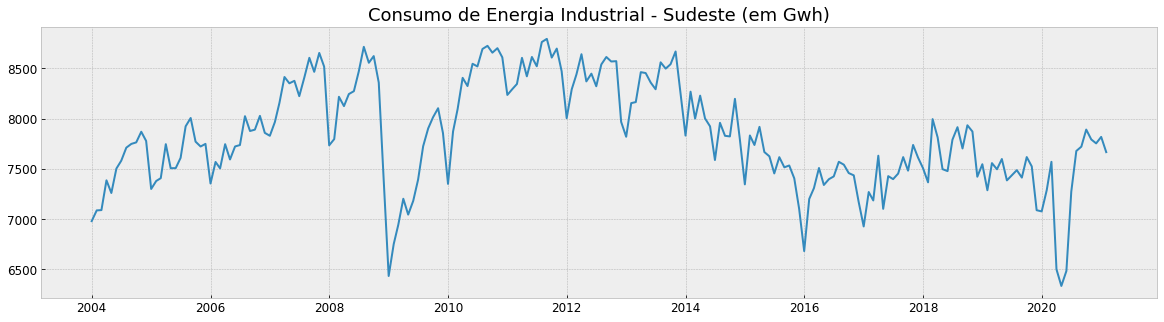

In [97]:
plt.figure(figsize=(20, 5))
plt.title('Consumo de Energia Industrial - Sudeste (em Gwh)', fontsize=18)
plt.plot(df[~df["ind_se"].isnull()].ind_se)
plt.show()

<a id="correlacoes"></a>
## 2.4. Correlações

In [98]:
# Normalização dos dados para que possamos comparar as curvas de variáveis diferentes numa mesma escala
df_eda = df[~df["ind_se"].isnull()]
index_dates = df_eda.index
scaler = StandardScaler()
scaler.fit(df_eda)  
df_eda = scaler.transform(df_eda)
df_eda = pd.DataFrame(df_eda, columns=df.columns, index=index_dates)

Agora vamos analisar a correlação das colunas, principalmente com nossa variável target - "ind_se". As variáveis com correlação mais forte são: 
* **pim_se - Produção Industrial (Região Sudeste)**: Faz total sentido que a produção e o consumo de energia sejam relacionados. Nossa variável mais importante.
* **ind_ne - Consumo de energia (Gwh) - Indústria - Região Nordeste)**: Apesar de fortemente correlacionada, talvez essa variável tenha uma relação espúria com nossa variável target. A princípio, não vejo relação óbvia entre as duas e talvez seja apenas coincidência. Além disso, não seria possível utilizar essa variável para previsão, dado que ela não é uma variável dada (não temos valores para datas futuras).
* **pim_s - Produção Industrial (Região Sul)**: Essa variável é interessante. Será que uma região pode ajudar no abastecimento de uma outra região ? Nesse caso a região Sul pode auxiliar no abastecimento da região Sudeste. Podemos analisar nas informações anteriores que a região Sudeste tem um consumo médio de 7.829 Gwh por mês, valor pouco mais de três vezes maior do que o consumo médio da região Sul (2.495 Gwh). Apesar disso, a produção média da região Sul é maior que a produção média da região Sudeste (96 vs. 90).

In [99]:
# Ordena variáveis de maior correlação com a variável dependente
corrmat = df.corr()
sorted_corrs = corrmat['ind_se'].abs().sort_values(ascending=False)
print(sorted_corrs)

ind_se         1.000000
pim_se         0.793250
ind_ne         0.754299
pim_s          0.683477
massa_r        0.625937
renda_r        0.535634
pim_ne         0.450059
pim_n          0.316463
pmc_a_co       0.301078
res_n          0.276200
res_ne         0.258035
res_co         0.253246
res_s          0.245775
temp_min_se    0.242553
pmc_a_ne       0.229778
pmc_a_se       0.218574
pmc_r_co       0.216244
temp_min_s     0.211779
ind_s          0.201316
com_ne         0.187855
temp_max_n     0.180960
temp_max_s     0.171490
pmc_a_n        0.156524
temp_min_n     0.152974
com_s          0.143222
com_n          0.135607
temp_min_co    0.132103
pmc_r_ne       0.130908
temp_min_ne    0.130096
res_se         0.127810
temp_max_co    0.116144
com_co         0.115085
ind_n          0.104751
pmc_a_s        0.102949
ind_co         0.091900
com_se         0.088309
temp_max_se    0.076352
pmc_r_n        0.067781
pmc_r_s        0.059158
pim_co         0.047890
pmc_r_se       0.046026
pop_ocup_br    0

<a id="producaoSudeste"></a>
### 2.4.1. Análise da Produção no Sudeste vs. Consumo no Sudeste

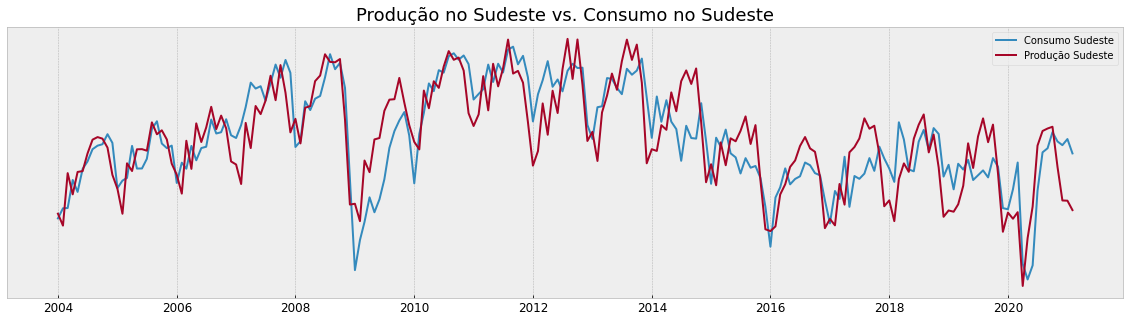

In [100]:
plt.figure(figsize=(20, 5))
plt.title('Produção no Sudeste vs. Consumo no Sudeste', fontsize=18)
plt.gca().axes.yaxis.set_visible(False)
plt.plot(df_eda.ind_se, label="Consumo Sudeste")
plt.plot(df_eda.pim_se, label="Produção Sudeste")
plt.legend()
plt.show()

<a id="consumoNordeste"></a>
### 2.4.2. Análise do Consumo no Nordeste vs. Consumo no Sudeste

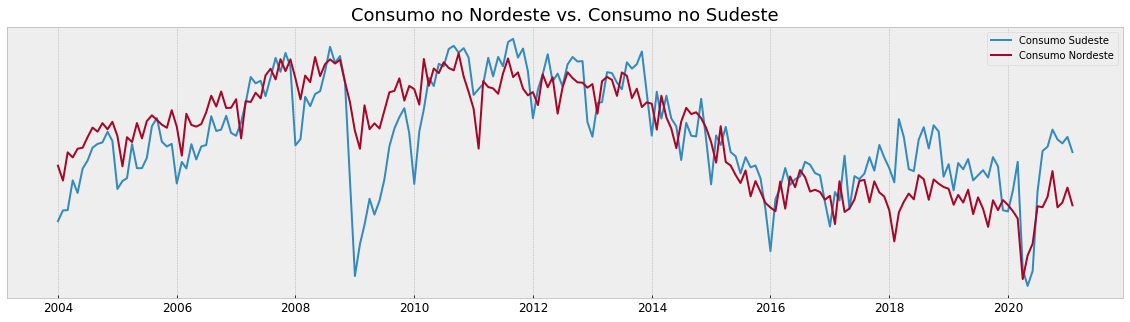

In [101]:
plt.figure(figsize=(20, 5))
plt.title('Consumo no Nordeste vs. Consumo no Sudeste', fontsize=18)
plt.gca().axes.yaxis.set_visible(False)
plt.plot(df_eda.ind_se, label="Consumo Sudeste")
plt.plot(df_eda.ind_ne, label="Consumo Nordeste")
plt.legend()
plt.show()

<a id="massaRendimento"></a>
### 2.4.3. Análise da Massa de Rendimento Real vs. Consumo no Sudeste

Temos apenas valores a partir de 2012 para a massa de rendimento, por isso foi necessário realizar o filtro.

Essa parece ser uma variável importante para o nosso modelo. Podemos tentar treinar com ela e também sem ela.

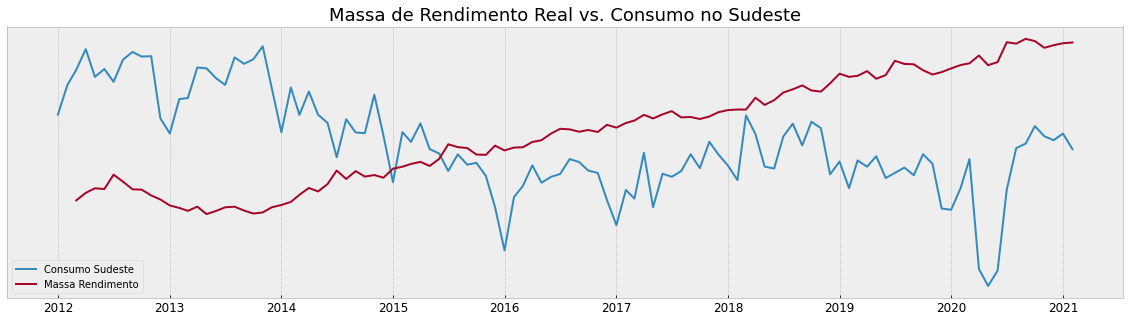

In [102]:
plt.figure(figsize=(20, 5))
plt.title('Massa de Rendimento Real vs. Consumo no Sudeste', fontsize=18)
plt.gca().axes.yaxis.set_visible(False)
plt.plot(df_eda.loc["2012-01-01":].ind_se, label="Consumo Sudeste")
plt.plot(df_eda.loc["2012-01-01":].massa_r, label="Massa Rendimento")
plt.legend()
plt.show()

<a id="matriz"></a>
### 2.4.4. Matriz

Para finalizar, abaixo temos uma análise de correlação gráfica entre todas as variáveis. As variáveis de Pesquisa tem correlação forte com quase todas as outras variáveis.

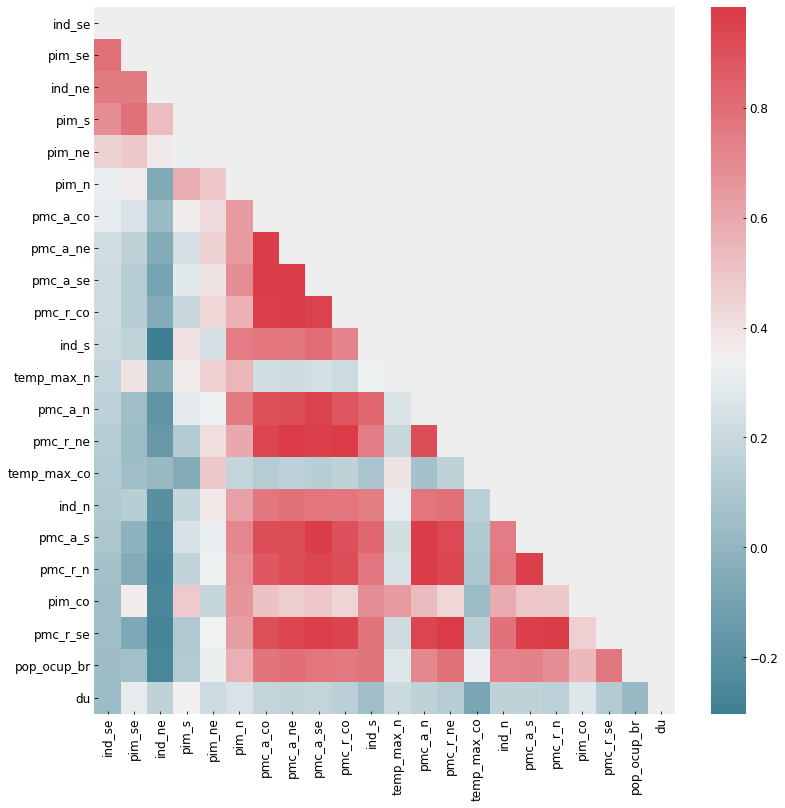

In [103]:
corr = df.corr()
top_corr_cols = corr[abs((corr.ind_se)>=0)].ind_se.sort_values(ascending=False).keys()
top_corr = corr.loc[top_corr_cols, top_corr_cols]
dropSelf = np.zeros_like(top_corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
plt.figure(figsize=(13, 13))
sns.heatmap(top_corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=False, fmt=".2f", mask=dropSelf)
plt.show()

<a id="remocaoColunas"></a>
## 2.5. Remoção de Colunas

Vamos remover as colunas com correlação abaixo de 0.6.

In [104]:
# Adiciona na lista variáveis que tem baixa correlação com o target
cols_to_drop = []
for i in range(0, len(sorted_corrs)):
    if sorted_corrs[i] < 0.6:
        cols_to_drop.append(sorted_corrs.index[i])

# Também vamos adicionar o consumo no Nordeste, já que não será utilizada para predição
cols_to_drop.append("ind_ne")
df = df.drop(cols_to_drop, axis=1)

<a id="outliers"></a>
## 2.6 Análise e Remoção de Outliers

Como já foi possível observar, em 2020 tivemos uma queda muito grande de consumo. No gráfico abaixo podemos ver claramente que em 2020 os meses de Abril, Maio e Junho chegaram a um patamar muito abaixo de qualquer outro ano. Além disso, os valores voltaram ao patamar normal a partir de Julho. Isso significa que precisamos tratar esses três meses, uma vez que podem ajudar a prever erroneamente os próximos meses

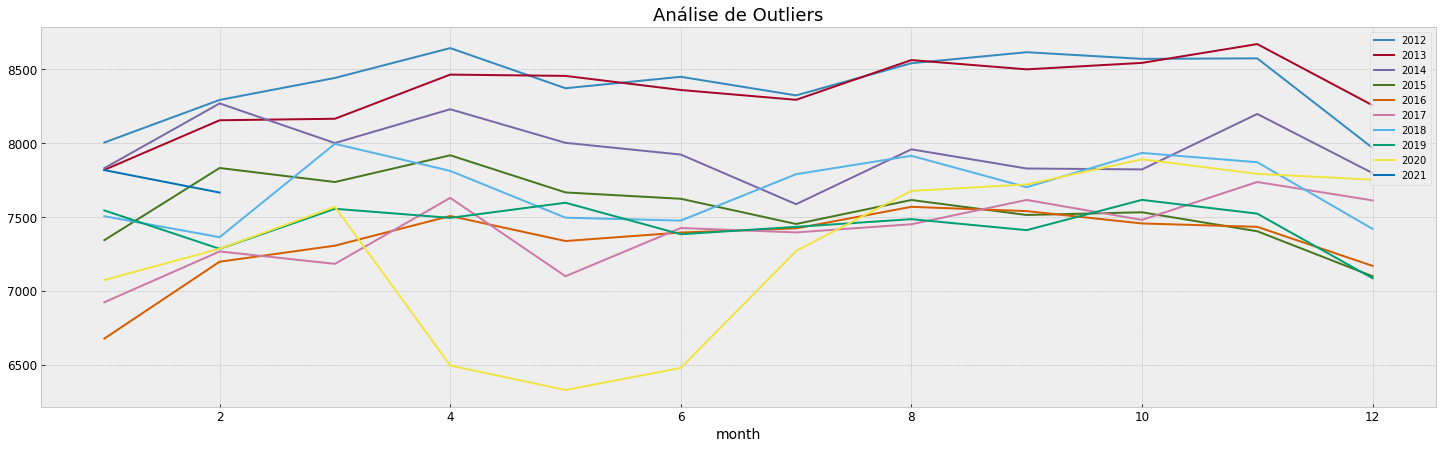

In [105]:
df_outlier = df.copy()[["ind_se"]]
df_outlier['date'] = df_outlier.index
df_outlier['month'] = df_outlier['date'].dt.month
df_outlier['year'] = df_outlier['date'].dt.year
df_outlier = df_outlier[~df_outlier["ind_se"].isnull()]
fig, ax = plt.subplots(figsize=(25, 7))
for year in range(2012, 2022):
    df_new = df_outlier[df_outlier["year"] == year]
    df_new.plot(x="month",y="ind_se", label=str(year), ax = ax)
plt.title('Análise de Outliers', fontsize=18)
plt.legend(loc='upper right')
plt.show()

Existem milhares de formas para tratar esses outliers. Com base no gráfico acima, podemos observar que **desde 2015 os meses de Abril, Maio e Junho ficavam em um patamar parecido**. Por isso, decidi substituir os nossos outliers pela média de 2015 a 2019 e para cada mês separadamente.

* Ou seja, o novo valor para Abril de 2020 será igual a média de Abril de 2015, Abril de 2016, Abril de 2017, Abril de 2018 e Abril de 2019.
* O novo valor para Maio de 2020 será igual a média de Maio de 2015, Maio de 2016, Maio de 2017, Maio de 2018 e Maio de 2019.

O mesmo vale para o mês de Junho.

In [106]:
df_mean = df_outlier[(df_outlier["year"] >= 2015) & (df_outlier["year"] < 2020)]
df_train = df.copy()
df_train['date'] = df_train.index
df_train['month'] = df_train['date'].dt.month
df_train['year'] = df_train['date'].dt.year
for month in range(4, 7):
    df_month = df_mean[(df_mean["month"] == month)]
    mean = np.mean(df_month["ind_se"])
    df_train.loc[(df_train["month"] == month) & (df_train["year"] == 2020), "ind_se"] = mean

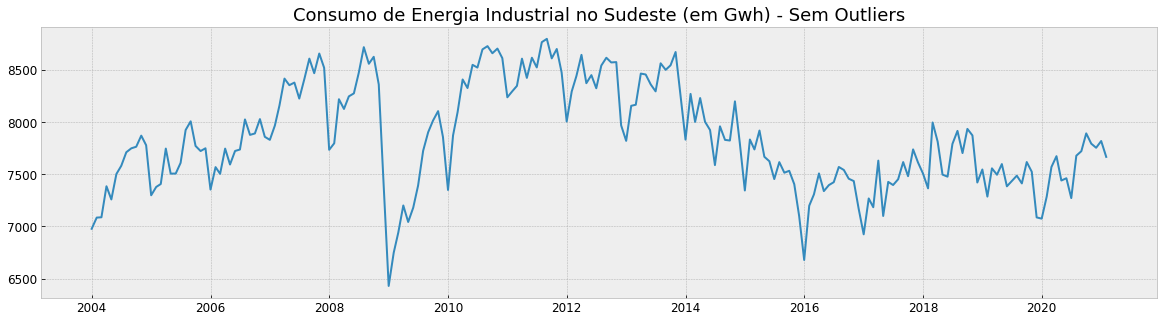

In [107]:
plt.figure(figsize=(20, 5))
plt.title('Consumo de Energia Industrial no Sudeste (em Gwh) - Sem Outliers', fontsize=18)
plt.plot(df_train[~df_train["ind_se"].isnull()].ind_se)
plt.show()

In [108]:
# Nossa base de treino será composta apenas de 2012 pra frente. Temos uma base completa e mais confiante dessa forma
dt_param = "2012-03-01"
df_train = df_train[~df_train["ind_se"].isnull()]
df_train = df_train.loc[dt_param:]

# Vamos manter a base com os valores reais também
df_original = df[~df["ind_se"].isnull()]
df_original = df_original.loc[dt_param:]

<a id="decomposicao"></a>
# 3. Decomposição da Serie Temporal

Uma análise importante é a decomposição das séries temporais em quatro partes: level, tendência, sazonalidade e ruído (erro). 

- **Level**: São os valores puros da série temporal, removidos tendência, sazonalidade e erro. Refere-se ao primeiro gráfico.
- **Tendência**: No nosso caso, no segundo gráfico, podemos ver claramente uma tendência de redução desde 2012.
- **Sazonalidade**: O terceiro gráfico evidencia a clara sazonalidade com pico sempre no segundo semestre do ano.
- **Erro**: No caso das séries temporais, ocorre muito o chamado white noise (ruído branco). Quando uma série temporal é white noise, os valores não tem relação com o passado, a média é zero e a variância é constante ao longo do tempo. Nesse caso, a série temporal é imprevisível. Não é o nosso caso.

Além disso, podemos ter um modelo aditivo ou multiplicativo. No primeiro caso, o modelo é linear. A tendência é linear e a sazonalidade tem frequência e amplitude constantes. No caso multiplicativo, na medida que os dados aumentam, a sazonalidade também aumenta. Como os próprios nomes já dizem, o modelo aditivo é representado por uma função de adição, enquanto que o multiplicativo é representado pela multiplicação das variáveis (o que faz com que sua amplitude ao longo do tempo seja muito maior).

Importante ressaltar que temos muitos casos em que a Serie Temporal é uma mistura (ou média) das duas. Porém podemos ver um lado predominante.

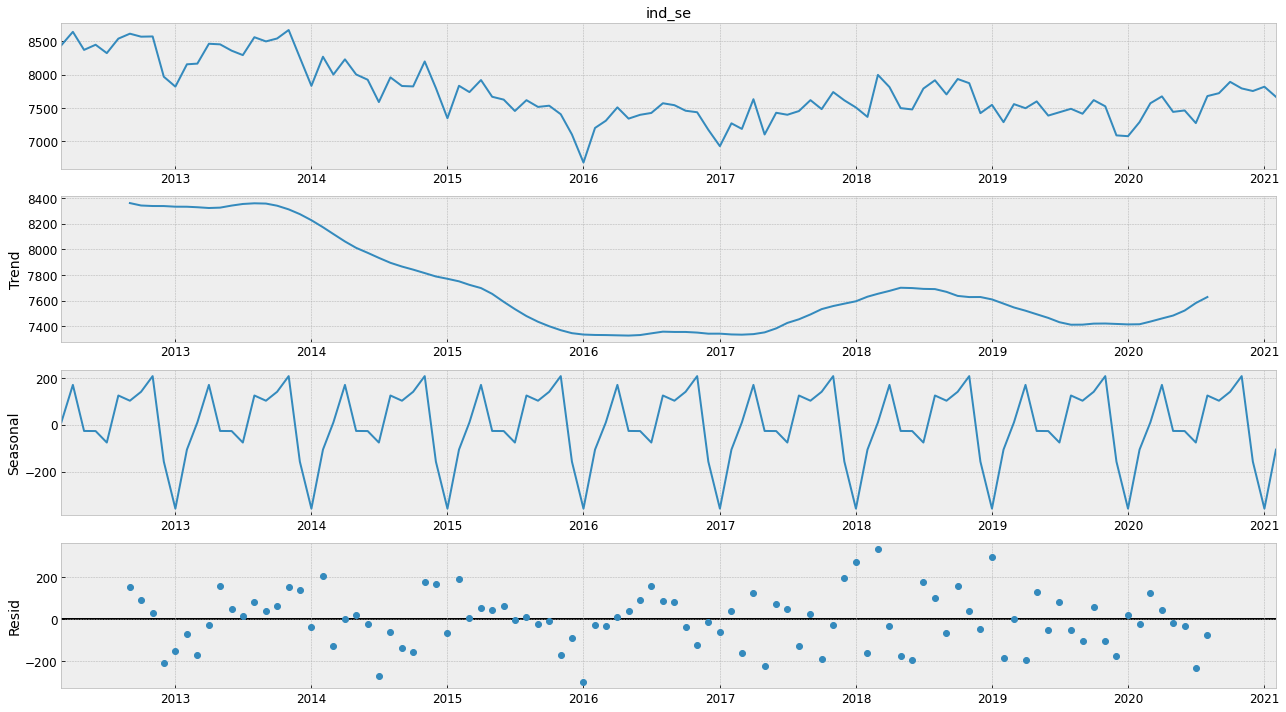

In [109]:
rcParams['figure.figsize'] = 18, 10
series = df_train.ind_se
result = seasonal_decompose(series, model='additive')
result.plot()
plt.show()

<a id="estacionariedade"></a>
# 4. Estacionariedade

Estacionariedade é um fator importante a ser analisado em um problema de Series Temporais. Uma Serie Temporal é estacionária se possui média e variância constantes. Podemos transformar uma Serie Temporal não estacionária para realizar o modelo mais facilmente.

<a id="autocorrelacao"></a>
## 4.1. Gráficos de Autocorrelação

os gráficos de autocorrelação mostram o quão relacionados os valores estão aos valores de outras datas (no nosso caso, por exemplo, o quanto o mês de Janeiro está relacionado ao mês de Fevereiro, ao mês de Março, etc.). No caso do gráfico ACF também conseguimos analisar a correlação indireta entre os meses (ou seja, a correlação que Janeiro teve em Fevereiro que, consequentemente, teve em Março).

Geralmente, em series não estacionárias, os valores são altamente correlacionados com pontos distantes. É o que ocorre no nosso caso.

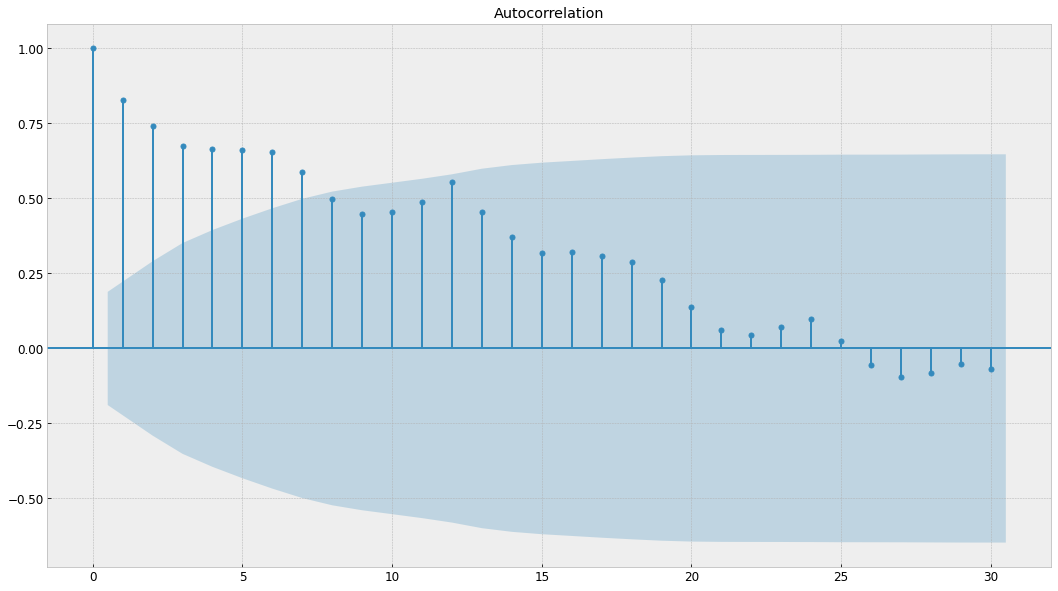

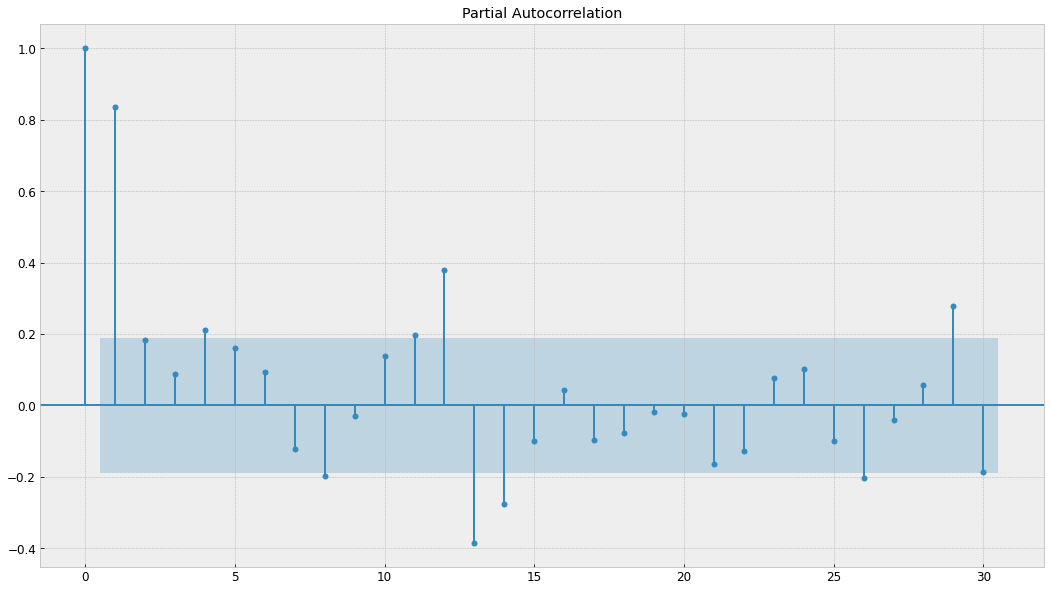

In [110]:
plot_acf(series, lags=30)
plot_pacf(series, lags=30)
plt.show()

<a id="testeDF"></a>
## 4.2. Teste de Estacionariedade Dickey-Fuller

Outro método para verificar a estacionariedade, e mais objetivo, é o teste Dickey-Fuller. Se o valor-p é superior ao limite imposto (normalmente de 5%, como será no nosso caso), assumimos que a serie temporal é não estacionária.

No nosso caso, uma vez que o valor é superior, assumimos estacionariedade. Esse problema será corrigido pelos próprios modelos mais à frente, por um método chamado diferenciação.

In [111]:
result = adfuller(df_train.ind_se.values)
print('valor-p:', result[1])

valor-p: 0.336763821852785


<a id="questoes23"></a>
# 5. Questões 2 e 3 (Previsão)

<a id="preparacaoDataset"></a>
## 5.1. Preparação do Dataset e Definição da Métrica

In [112]:
# Vamos deixar como teste 24 meses
split_date = '2019-02-01'
df_train.drop(["month", "year", "date"], axis=1, inplace=True)
df_training = df_train.loc[df_train.index <= split_date]
df_test = df_original.loc[df_original.index > split_date]
print(f"{len(df_training)} meses de treino \n{len(df_test)} meses de teste ")

84 meses de treino 
24 meses de teste 


#### Definição da Métrica

Antes de começarmos a realizar previsões, é definirmos a métrica. Qual nosso objetivo? O que é um modelo bom?

Para termos um parâmetro, vou utilizar simplesmente a média aritmética do nosso target e calcular três erros: Erro Absoluto Médio (MAE), Raiz do Erro Quadrático Médio (RMSE) e Erro Absoluto Médio Percentual (MAPE). Para esse exercício, vou me focar no MAE.

Como podemos ver abaixo, **caso a gente prevesse os valores simplesmente com a média para nossa base teste, teríamos um erro de 413. Isso significa que qualquer valor abaixo disso é lucro.**

In [113]:
# Vamos criar um dicionário para colocar os resultados de cada modelo
dict_results = {}

# Also add the naive mean average value
mean = df_training.ind_se.mean()
mean = np.array([mean for u in range(len(df_test))])
dict_results['Mean'] = evaluate(df_test.ind_se, mean)
print(dict_results["Mean"])

{'mae': 413.44538809523766, 'rmse': 579.678032589196, 'mape': 0.05948501128394204}


<a id="modelosUnivariados"></a>
## 5.2. Modelos Univariados de Séries Temporais

<a id="sarima"></a>
### 5.2.1. SARIMA e Resposta da Questão 2

Uma extensão do modelo ARIMA, o modelo SARIMA também possui um parâmetro para a sazonalidade.

### Questão 2 (Respostas)

**Utilizando-se das variáveis fornecidas na base de dados Bases Final ADS Jun2021.xlsx, forneça um modelo que projete, com a melhor acurácia possível, o consumo de energia industrial da região Sudeste para os próximos 24 meses.**
- Mais abaixo, podemos observar o gráfico gerado por um modelo SARIMA para os próximos 24 meses. O Erro Absoluto Médio (MAE) foi de 289. A redução do erro será desenvolvida ao longo do projeto.

**1. Explique o método e a razão de utilizar a abordagem escolhida na sua projeção. Quais “insights” podem ser obtidos da modelagem?**
- O primeiro modelo escolhido foi o SARIMA, já que é um modelo flexível por possuir parâmetros para todos os componentes necessários em nosso problema (sazonalidade, tendência e diferenciação). Podemos observar que depois de uma alta queda (provavelmente devido a pandemia), os valores estão voltando ao patamar anterior e devem se manter assim por algum tempo.

**2. Forneça medidas para avaliar a qualidade da projeção do modelo**
- As medidas escolhidas foram o Erro Absoluto Médio (MAE), Raiz do Erro Quadrático Médio (RMSE) e Erro Absoluto Médio Percentual (MAPE). Meu foco será no MAE, em comparação com a previsão a partir da média artimética.

**3. Justifique a escolha das variáveis explicativas e avalie o poder explicativo delas.**
- Nesse primeiro momento, realizei um modelo que utiliza apenas o nosso target. As variáveis serão utilizadas futuramente.

In [114]:
# Criação de lista para adicionar os valores previstos
predictions_list = list()

# Iteração para sempre utilizar o número máximo de valores possíveis. 
# Ou seja, para previsão no tempo t, utilizaremos
# a base de treino até o tempo t-1
for t in range(len(df_test.ind_se)):
    temp_train = df_train[:len(df_training)+t]
    
    # Criação e fitting do modelo SARIMA
    model = SARIMAX(temp_train.ind_se, 
                    order=(1, # temos valores positivos significaticos (ACF)
                           1, # precisamos realizar diferenciação 
                           0), # não temos valores negativos significativos (ACF)
                    seasonal_order=(1, # P = temos valores positivos significativos (PACF)
                                    1, # D = temos sazonalidade
                                    1, # Q = temos valores negativos significativos (PACF)
                                    12), # S = sazonalidade de 12 meses
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    
    # Previsão do valor e adição dele na lista de previsões
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    predictions_list = predictions_list + [predictions]

# Conversão da lista em uma Series e cálculo das métricas
predictions_list = pd.concat(predictions_list)
dict_results['SARIMAX'] = evaluate(df_test.ind_se, predictions_list.values)
print(dict_results['SARIMAX'])

{'mae': 289.2804399517266, 'rmse': 426.1363872325905, 'mape': 0.04138202162456891}


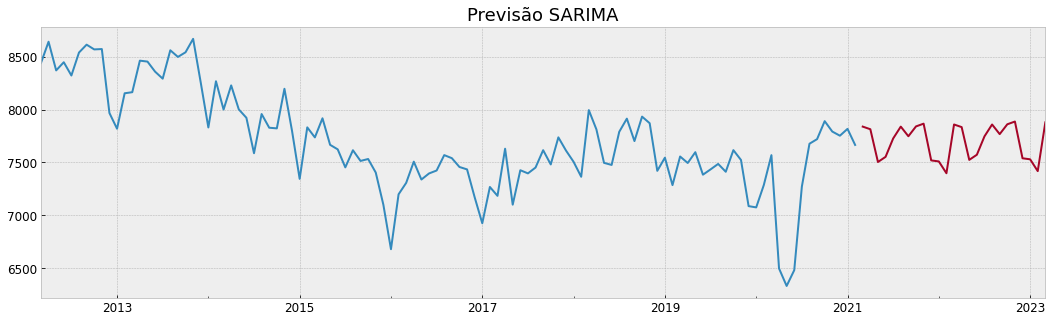

In [115]:
model = SARIMAX(df_training.ind_se,
                order=(1, 1, 0), 
                seasonal_order=(1, 1, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)
model_fit = model.fit(disp=False)
predictions = model_fit.predict(start=len(df_train), end=len(df_train)+24, dynamic=False)

df_original['ind_se'].plot(figsize=(18,5),legend=False)
predictions.plot()
plt.gca().axes.set_xlabel(None)
plt.title("Previsão SARIMA", fontsize=18)
plt.show()

<a id="questao3"></a>
### 5.2.2. Resposta da Questão 3

**Levando em consideração a modelagem apresentada acima, escolha os 5 melhores modelos em termos de acurácia e argumente a razão de tê-los escolhido.**

Abaixo serão apresentados dois outros modelos para séries temporais: ARIMA e Suavização Exponencial de Holt. O modelo ARIMA foi escolhido para verificarmos o comportamento das previsões sem um fator de sazonalidade. Já o modelo de Winter-Holt, é um modelo largamente utilizado para séries temporais que funciona bem quando temos uma série temporal não estacionária. Além disso, resolvi testar os modelos lineares de Ridge e Lasso. Nestes, utilizei as variáveis que tiveram uma correlação de 0.6 ou mais com nossa variável target, além de criar duas outras variáveis a partir da data: ano e mês.

<a id="arima"></a>
### 5.2.3. ARIMA

O modelo ARIMA é uma combinação dos modelos de Autorregressão (AR) e de Moving Average (MA). Além disso, possui um parâmetro para diferenciação.

In [116]:
# A ideia é a mesma do modelo SARIMA
predictions_list = list()
pred_index = predictions.index
for t in tqdm(range(len(df_test.ind_se))):
    temp_train = df_train[:len(df_training)+t]
    model = ARIMA(temp_train.ind_se, order=(4, 0, 1))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    predictions_list = predictions_list + [predictions]
predictions_list = pd.concat(predictions_list)
dict_results['ARIMA'] = evaluate(df_test.ind_se, predictions_list.values)

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:11<00:00,  2.16it/s]


<a id="holt"></a>
### 5.2.4. Suavização Exponencial de Holt (HWES)

Modelo muito utilizado para séries temporais. Esse foi um dos modelos escolhidos por ser simples e eficiente. Ele geralmente funciona bem quando a série não é estacionária e é um modelo que pesa os resultados recentes.

In [117]:
predictions_list = list()
for t in range(len(df_test.ind_se)):
    temp_train = df_train[:len(df_training)+t]
    model = ExponentialSmoothing(temp_train.ind_se)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    predictions_list = predictions_list + [predictions]
predictions_list = pd.concat(predictions_list)
dict_results['HWES'] = evaluate(df_test.ind_se, predictions_list.values)

<a id="modelosMultivariados"></a>
## 5.3. Modelos Multivariados de Séries Temporais

<a id="preparacaoDados"></a>
### 5.3.1. Preparação dos Dados

Essa etapa consiste em criar duas novas variáveis (ano e mês) a partir da nossa data. Fazemos também a divisão do nosso dataset em treino e teste. Por fim, normalizamos as variáveis para evitar que uma delas tenha um peso muito alto na previsão

In [118]:
def create_time_features(df, target=None):
    """Criação de variáveis de tempo"""
    df['date'] = df.index
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    X = df.drop(['date'], axis=1)
    if target:
        y = df[target]
        X = X.drop([target], axis=1)
        return X, y

    return X

In [119]:
# Divisão do dataset e normalização das variáveis
X_train_df, y_train = create_time_features(df_training, target='ind_se')
X_test_df, y_test = create_time_features(df_test, target='ind_se')
scaler = StandardScaler()
scaler.fit(X_train_df)
X_train = scaler.transform(X_train_df)
X_test = scaler.transform(X_test_df)
X_train_df = pd.DataFrame(X_train, columns=X_train_df.columns)
X_test_df = pd.DataFrame(X_test, columns=X_test_df.columns)

<a id="modelosLineares"></a>
### 5.3.2. Modelos Lineares

Para os modelos multivariados, utilizei os modelos lineares Ridge e Lasso, uma vez que a série temporal tem uma tendência linear. Além disso, os modelos Ridge e Lasso geram uma penalização nos coeficientes. No nosso caso isso é positivo, já que parece existir multicolinearidade entre as variáveis.

<a id="ridge"></a>
#### 5.3.2.1 Ridge

In [120]:
ridge = linear_model.BayesianRidge()
ridge.fit(X_train, y_train)
predictions_list = ridge.predict(X_test)
dict_results['Ridge'] = evaluate(df_test.ind_se, predictions_list)

<a id="lasso"></a>
#### 5.3.2.2. Lasso

In [121]:
lasso = linear_model.Lasso()
lasso.fit(X_train, y_train)
predictions_list = lasso.predict(X_test)
dict_results['Lasso'] = evaluate(df_test.ind_se, predictions_list)

<a id="resultados"></a>
# 6. Resultados

O modelo que teve melhor comportamento foi o modelo Lasso, com um erro de 216. 

In [122]:
df = pd.DataFrame.from_dict(dict_results).transpose().iloc[::-1]
for col in ["mae", "rmse"]:
    df[col] = df[col].round(2)
df["mape"] = round(df["mape"] * 100, 2)
df

,mae,rmse,mape
Lasso,216.22,295.66,2.96
Ridge,232.34,312.89,3.18
HWES,254.54,407.28,3.69
ARIMA,245.30,403.62,3.57
SARIMAX,289.28,426.14,4.14
Mean,413.45,579.68,5.95


<a id="questao4"></a>
# 7. Questão 4

**O que é possível tirar de conclusões a partir dos exercícios 1, 2, e 3?**

Ficou claro que temos um problema de séries temporais. O consumo de energia no Sudeste tem um movimento cíclico ao longo do ano. No início da última década teve uma tendência de queda, porém depois parece ter se mantido em um patamar. A pandemia do coronavírus teve uma clara influência entre 2020 e 2021 e a partir de agora parece que o nível de consumo voltou ao patamar que se apresentava antes do início da pandemia e deve se manter assim pelos próximos anos.

<a id="otimizacao"></a>
# 8. Otimização de Hiperparâmetros

<a id="otimizacaoLinear"></a>
## 8.1. Otimização dos Modelos Lineares

Realizando uma otimização de parâmtetros no nosso modelo Lasso, chegamos a um MAE de 193.

In [123]:
def lasso_grid_search(alpha_list, selection_list=['cyclic', "random"], mae_init=1000, max_iter=1000):
    best_mae = mae_init
    for alpha in alpha_list:
        for selection in selection_list:
            lasso = linear_model.Lasso(alpha=alpha, selection=selection, max_iter=max_iter)
            lasso.fit(X_train, y_train)
            predictions_list = lasso.predict(X_test)
            results = evaluate(df_test.ind_se, predictions_list)
            if results["mae"] < best_mae:
                best_mae = results["mae"]
                print('ALPHA {} x {}: MAE Calculated = {}'.format(alpha, selection, results["mae"]))

In [124]:
alpha_list = [10, 5, 2, 1, 0.5, 0.1, 0.01, 0, -1, -5, -10]
lasso_grid_search(alpha_list=alpha_list, max_iter=3000)

ALPHA 10 x cyclic: MAE Calculated = 223.48148730978434
ALPHA 10 x random: MAE Calculated = 223.47701675703794
ALPHA 2 x cyclic: MAE Calculated = 221.0237931418753
ALPHA 1 x cyclic: MAE Calculated = 216.21875033458448
ALPHA 0.5 x cyclic: MAE Calculated = 213.75889305391115
ALPHA 0.5 x random: MAE Calculated = 213.74106535416345
ALPHA 0.1 x cyclic: MAE Calculated = 211.4111608214174
ALPHA 0.1 x random: MAE Calculated = 211.40914627306336
ALPHA 0.01 x cyclic: MAE Calculated = 210.8859414366054
ALPHA 0.01 x random: MAE Calculated = 210.88583764805756
ALPHA 0 x cyclic: MAE Calculated = 210.82756203732922
ALPHA 0 x random: MAE Calculated = 210.82756203732902
ALPHA -1 x cyclic: MAE Calculated = 205.69656423656673
ALPHA -5 x cyclic: MAE Calculated = 193.93490175481216


<a id="otimizacaoARIMA"></a>
## 8.2. Otimização dos Modelos ARIMA e SARIMA

Vamos utilizar o Grid Search no nosso modelo SARIMA para buscarmos os melhores valores para nossos parâmetros. Essa parte pode demorar para rodar dependendo da quantidade de combinações, mas consegui alcançar um erro de 220.

Nessa parte peguei parte do código [aqui](https://towardsdatascience.com/grid-search-for-sarimax-parameters-adbd5104cb8b)

In [125]:
def sarimax_gridsearch(pdq, pdqs, maxiter=100):
    """Busca dos melhores parâmetros para o modelo SARIMA"""
    best_mae = 1000
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                predictions_list = list()
                for t in range(len(df_test.ind_se)):
                    temp_train = df_train[:len(df_training)+t]
                    model = SARIMAX(temp_train.ind_se, 
                                    order=comb,
                                    seasonal_order=combs,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
                    model_fit = model.fit(disp=False)
                    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
                    predictions_list = predictions_list + [predictions]
                predictions_list = pd.concat(predictions_list)
                results = evaluate(df_test.ind_se, predictions_list.values)
                ans = [[comb, combs, results["mae"], results["rmse"], results["mape"]]]
                if results["mae"] < best_mae:
                    best_mae = results["mae"]
                    print('SARIMAX {} x {}: MAE Calculated = {}'.format(comb, combs, results["mae"]))
            except:
                continue
            
    return 


def arima_gridsearch(pdq, maxiter=100):
    """Busca dos melhores parâmetros para o modelo ARIMA"""
    best_mae = 1000
    ans = []
    for comb in pdq:
        try:
            predictions_list = list()
            for t in range(len(df_test.ind_se)):
                temp_train = df_train[:len(df_training)+t]
                model = ARIMA(temp_train.ind_se, order=comb)
                model_fit = model.fit(disp=False)
                predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
                predictions_list = predictions_list + [predictions]
            predictions_list = pd.concat(predictions_list)
            results = evaluate(df_test.ind_se, predictions_list.values)
            if results["mae"] < best_mae:
                best_mae = results["mae"]
                ans = [[comb, results["mae"], results["rmse"], results["mape"]]]
                print('ARIMA {}: MAE Calculated = {}'.format(comb, results["mae"]))
        except:
            continue
            
    return 

In [126]:
# Calcula todas as combinações possíveis
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [127]:
print("{} modelos SARIMA serão calculados".format(len(pdq) * len(pdqs)))
print("{} modelos ARIMA serão calculados".format(len(pdq)))

64 modelos SARIMA serão calculados
8 modelos ARIMA serão calculados


In [128]:
arima_gridsearch(pdq)

ARIMA (0, 0, 0): MAE Calculated = 391.8520012281697
ARIMA (0, 0, 1): MAE Calculated = 322.7437897057682
ARIMA (1, 0, 0): MAE Calculated = 269.7782873714128
ARIMA (1, 0, 1): MAE Calculated = 258.96097980446757


In [129]:
# sarimax_gridsearch(pdq, pdqs)

<a id="melhorias"></a>
# 9. Possíveis Melhorias

O modelo chegou a um MAE de 250, porém ainda tem muito a ser feito. Algumas sugestões futuras:
* Criação de outros modelos multivariados, inclusive utilizando o SARIMA
* Criação de modelos de Redes Neurais (LSTM é utilizada para previsão de séries temporais)
* Cross Validation
* Feature Engineering (criação de variável para estação do ano, por exemplo)